# Regressão Linear Múltipla com Elimininação Retroativa

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time

from functools import wraps
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Carregando Base de Dados

In [2]:
!rm -r MLUD
!git clone https://github.com/Crissky/MLUD.git

Cloning into 'MLUD'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 106 (delta 39), reused 30 (delta 4), pack-reused 0
Receiving objects: 100% (106/106), 130.73 KiB | 5.03 MiB/s, done.
Resolving deltas: 100% (39/39), done.


## Funções de Pré-Processamento

In [3]:
def loadDataset(filename):
    baseDeDados = pd.read_csv(filename, delimiter=';')
    X = baseDeDados.iloc[:,:-1].values
    y = baseDeDados.iloc[:,-1].values
    return X, y

def fillMissingData(X, inicioColuna, fimColuna):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    X[:,inicioColuna:fimColuna + 1] = imputer.fit_transform(X[:,inicioColuna:fimColuna + 1])
    return X

#só funciona se i = 0 ou i = ultima coluna
def computeCategorization(X, i):
    labelencoder_X = LabelEncoder()
    X[:, i] = labelencoder_X.fit_transform(X[:, i])

    #one hot encoding
    D = pd.get_dummies(X[:,i]).values
    if(i == 0):
        X = X[:,1:]
        X = np.insert(X, 0, D, axis=1)

        #removendo dummy variable trap
        X = X[:,1:]
    else:
        X = X[:,:i]
        for j in range(0, D.shape[1]):
            X = np.insert(X, i, D[:,j], axis=1)

        #removendo dummy variable trap
        X = X[:,:-1]
    return X

def splitTrainTestSets(X, y, testSize):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = testSize)
    return XTrain, XTest, yTrain, yTest

def computeScaling(train, test):
    scaleX = StandardScaler()
    train = scaleX.fit_transform(train)
    test = scaleX.fit_transform(test)
    return train, test

## Regressão Linear

In [4]:
def computeLinearRegressionModel(XTrain, yTrain, XTest, yTest):
    regressor = LinearRegression()
    regressor.fit(XTrain, yTrain)
    #yPred = regressor.predict(XTest)

    #gerar grafico
    plt.scatter(XTest[:,-1], yTest, color="red")
    plt.plot(XTest[:,-1], regressor.predict(XTest), color="blue")
    plt.title("Inscritos x Visualizações (SVBR)")
    plt.xlabel("Total de Inscritos")
    plt.ylabel("Total de Visualizações")
    plt.show()

def runLinearRegressionExample(filename):
    start_time = time.time()
    X, y = loadDataset(filename)
    elapsed_time = time.time() - start_time
    print("Load Dataset: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    X = fillMissingData(X, 1, X.shape[1])
    elapsed_time = time.time() - start_time
    print("Fill Missing Data: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    X = computeCategorization(X, 0)
    elapsed_time = time.time() - start_time
    print("Compute Categorization: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    XTrain, XTest, yTrain, yTest = splitTrainTestSets(X, y, 0.8)
    elapsed_time = time.time() - start_time
    print("Split Train Test sets: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    computeLinearRegressionModel(XTrain, yTrain, XTest, yTest)
    elapsed_time = time.time() - start_time
    print("Compute Linear Regression: %.2f" % elapsed_time, "segundos.")    

Load Dataset: 0.01 segundos.
Fill Missing Data: 0.00 segundos.
Compute Categorization: 0.00 segundos.
Split Train Test sets: 0.00 segundos.


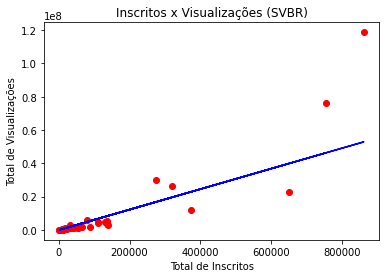

Compute Linear Regression: 0.16 segundos.


In [5]:
runLinearRegressionExample("MLUD/Aula06/svbr.csv")

## Regressão Linear Múltipla com Elimininação Retroativa

In [6]:
def computeMultipleLinearRegressionModel(XTrain, yTrain, XTest, yTest):
    regressor = LinearRegression()
    regressor.fit(XTrain, yTrain)

    yPred = regressor.predict(XTest)
    print('\n#########################INÍCIO#########################')
    print('\nIniciando comparação:\nPREDITO | ESPERADO | DIFERENÇA\n')
    for i in range(0, yPred.shape[0]):
        print(yPred[i], yTest[i], abs(yPred[i] - yTest[i]))
        # time.sleep(0.5)
    print('\n##########################FIM##########################\n')
        
def computeMLRWithBackwardElimination(X, y, XTest):
    X = np.insert(X, 0, 1, axis=1)                    #Inserindo constante
    XOtimo = X[:,[0, 1, 2, 3, 4, 5, 6]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit() #OLS só funciona com float
    # print(regressor.summary())
    # print(XOtimo[1,:])

    XOtimo = X[:,[0, 1, 2, 3, 4, 6]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    # print(regressor.summary())
    # print(XOtimo[1,:])
    
    XOtimo = X[:,[0, 1, 2, 3, 4]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    # print(regressor.summary())
    # print(XOtimo[1,:])

    XOtimo = X[:,[0, 1, 2, 3]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    # print(regressor.summary())
    # print(XOtimo[1,:])

    XOtimo = X[:,[0, 1, 2]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    # print(regressor.summary())
    # print(XOtimo[1,:])

    XTest = XTest[:,[0, 1, 2]]

    return XOtimo, XTest

def computeAutomaticBackwardElimination(XTrain, yTrain, XTest, sl):
    XTrain = np.insert(XTrain, 0, 1, axis=1)                      #Inserindo constante
    XTest = np.insert(XTest, 0, 1, axis=1)                        #Inserindo constante
    numVars = len(XTrain[0])

    print()
    for i in range(0, numVars):
      regressor_OLS = sm.OLS(yTrain, XTrain.astype(float)).fit()  #OLS só funciona com float
      maxVar = max(regressor_OLS.pvalues).astype(float)
      if(maxVar > sl):
          for j in range(0, numVars - i):
              if(regressor_OLS.pvalues[j].astype(float) == maxVar):
                  print("Deletando coluna:", j)
                  XTrain = np.delete(XTrain, j, axis=1)
                  XTest = np.delete(XTest, j, axis=1)
    
    print()
    # regressor_OLS.summary()
    return XTrain, XTest
def runMultipleLinearRegressionExample(filename):
    start_time = time.time()
    X, y = loadDataset(filename)
    elapsed_time = time.time() - start_time
    print("Load Dataset: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    X = fillMissingData(X, 1, 2)
    elapsed_time = time.time() - start_time
    print("Fill Missing Data: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    X = computeCategorization(X, 3)
    elapsed_time = time.time() - start_time
    print("Compute Categorization: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    XTrain, XTest, yTrain, yTest = splitTrainTestSets(X, y, 0.8)
    elapsed_time = time.time() - start_time
    print("Split Train Test sets: %.2f" % elapsed_time, "segundos.")

    # start_time = time.time()
    # XTrain, XTest = computeMLRWithBackwardElimination(XTrain, yTrain, XTest)
    # elapsed_time = time.time() - start_time
    # print("Compute MLR with Backward Elimination: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    XTrain, XTest = computeAutomaticBackwardElimination(XTrain, yTrain, XTest, 0.05)
    elapsed_time = time.time() - start_time
    print("Compute Automatic Backward Elimination: %.2f" % elapsed_time, "segundos.")

    start_time = time.time()
    computeMultipleLinearRegressionModel(XTrain, yTrain, XTest, yTest)
    elapsed_time = time.time() - start_time
    print("Compute Multiple Linear Regression: %.2f" % elapsed_time, "segundos.")

In [7]:
runMultipleLinearRegressionExample("MLUD/Aula06/insurance.csv")

Load Dataset: 0.01 segundos.
Fill Missing Data: 0.00 segundos.
Compute Categorization: 0.00 segundos.
Split Train Test sets: 0.00 segundos.

Deletando coluna: 6
Deletando coluna: 5
Deletando coluna: 4
Deletando coluna: 3

Compute Automatic Backward Elimination: 0.01 segundos.

#########################INÍCIO#########################

Iniciando comparação:
PREDITO | ESPERADO | DIFERENÇA

6037.2465208958 32734.1863 26696.9397791042
20132.18696257733 15161.5344 4970.652562577328
7311.537356106426 3206.49135 4105.046006106426
15345.32780396337 5836.5204 9508.807403963368
9732.451447054525 33475.81715 23743.365702945477
9527.784206856544 5257.50795 4270.276256856544
14567.00310499726 11244.3769 3322.626204997261
12226.179371160015 6940.90985 5285.269521160015
17409.80145240139 27322.733860000004 9912.932407598615
12873.284686401079 23244.7902 10371.50551359892
14553.30055927256 6186.1269999999995 8367.17355927256
16721.50907979451 8835.26495 7886.244129794508
13145.98947229045 2534.39375 10